# TWITTER SENTIMENT ANALYSIS - COVID-19

The aim of this project is to create a machine learning model for sentiment analysis related to covid-19 data on Twitter. In order to do that, as a labeled NLP dataset for covid-19 data does not currently exist, we will try to train our models using some old datasets from the past years found on the Internet. We will need to preprocess all the twitter datasets (removal, lowercasing, tokenizing, padding...), train some models (neural networks) and finally, apply their predictions to some tweets that the team has been collecting for the last few days in order to visualize the results. We will also try to correlate the positive/negative feelings to some remarkable dates of Spain from the last month.


José Antonio Álvarez Marí - Team E

### - NOTE THAT SOME CELLS ARE COMMENTED IN ORDER TO NOT WASTE TIME

---
# Preprocess

I import the necessary libraries for the correct developing of the project.

In [1]:
import collections
from collections import Counter

from datetime import datetime
from IPython.display import Image as im
import itertools
import matplotlib.pyplot as plt


import nltk
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.chunk.regexp import *
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer


import numpy as np
import pandas as pd


from PIL import Image
import re
import seaborn as sns
import ssl
import string
from textblob import TextBlob
import xml.etree.ElementTree as et


from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import os, re, codecs
from tqdm import tqdm



import keras
from keras import layers
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, LSTM, GRU, Bidirectional
from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


This is where I access the twitter input files and I formate and concatenate them into one file.

In [2]:
# Se accede al fichero txt, se convierte en un dataset de Pandas, se eliminan todos aquellos tweets
# con sentimiento neutral.

out_df = pd.read_csv("./65000.txt", error_bad_lines=False, sep='\t', header=None, names=['tweet','value'])
out_df = out_df[out_df.value != 'Neutral']   #Eliminamos todos aquellos tweets con sentimiento neutral.

out_df3 = pd.read_csv("./7000.txt", error_bad_lines=False, sep='\t', header=None, names=['tweet','value'])
out_df3 = out_df3[out_df3.value != 'Neutral']   #Eliminamos todos aquellos tweets con sentimiento neutral.


func1 = lambda x: 1 if x == "Positive" else 0 #Pasamos el valor Positivo o Negativo a codificacion binaria.
out_df.value = out_df.value.apply(func1)
out_df3.value = out_df3.value.apply(func1)



def parse_XML_TASS(xml_file): 
    """Parse the input XML file and store the result in a pandas 
    DataFrame with the given columns. 
    
    The first element of df_cols is supposed to be the identifier 
    variable, which is an attribute of each node element in the 
    XML data; other features will be parsed from the text content 
    of each sub-element. 
    """
    
    xtree = et.parse(xml_file)
    xroot = xtree.getroot()
    rows = []
    
    for node in xroot:
        tweet = node.find('content').text
        date = pd.to_datetime(node.find('date').text, format='%a %b %d %H:%M:%S %z %Y')
        value = node.find('sentiment').find('polarity').find('value').text

        if (value == 'P'):
            valueNum = 1
        elif (value == 'N'):
            valueNum = -1
        else:
            valueNum = 0

        rows.append({'tweet': tweet, 'date': date, 'value': valueNum})
    
    out_df = pd.DataFrame(rows, columns = ['tweet', 'date', 'value'])
        
    return out_df

out_df_ES = parse_XML_TASS('./tweets/TASS2019_country_ES_train.xml')
out_df_CR = parse_XML_TASS('./tweets/TASS2019_country_CR_train.xml')
out_df_MX = parse_XML_TASS('./tweets/TASS2019_country_MX_train.xml')
out_df_PE = parse_XML_TASS('./tweets/TASS2019_country_PE_train.xml')
out_df_UY = parse_XML_TASS('./tweets/TASS2019_country_UY_train.xml')

out_df2 = pd.concat([out_df_ES, out_df_CR, out_df_MX, out_df_PE, out_df_UY])


out_df2 = out_df2[out_df2.value != 0]   #Eliminamos todos aquellos tweets con sentimiento neutral.



func1 = lambda x: 1 if x == 1 else 0 #Pasamos el valor Positivo o Negativo a codificacion binaria.
out_df2.value = out_df2.value.apply(func1)


out_df2 = out_df2.reset_index()
out_df2 = out_df2.drop(columns=['date','index'])




out_df = pd.concat([out_df, out_df2, out_df3]) # Concatenacion de los 3 ficheros.

I apply text cleaning techniques such as stop-words removal, puntuaction removal, lowercase the text... 

In [3]:
# Text cleaning techniques

# Eliminamos tweets incompletos (aquellos que tienen una parte del tweet y un enlace al tweet completo)
#out_df = out_df[~out_df['tweet'].str.contains("https://", regex=False)]
#out_df = out_df[~out_df['tweet'].str.contains("http://", regex=False)]
out_df = out_df.reset_index()
out_df = out_df.drop(columns=['index'])



def clean_text_round1(text):
    #Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.
    text = text.lower()
    text = re.sub('\[.*?¿\]\%', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r"http\S+", "", text) 
    text = re.sub('@[^\s]+', '', text) #-->remove usernames
    text = re.sub(r'#([^\s]+)', r'\1', text) #-->remove the # in #hashtag
    return text
 


# Apply a second round of cleaning
def clean_text_round2(text):
    #Get rid of some additional punctuation and non-sensical text that was missed the first time around.
    text = re.sub('[‘’“”…«»]', '', text)
    text = re.sub('\n', ' ', text)
    return text
 
    
    
round1 = lambda x: clean_text_round1(x)
out_df['tweet'] = out_df['tweet'].apply(clean_text_round1)

    
    
round2 = lambda x: clean_text_round2(x)
out_df['tweet'] = out_df['tweet'].apply(clean_text_round2)


##########################################################################################################
##########################################################################################################
##########################################################################################################


# Se eliminan todos los stopwords en español

out_df["tweet"] = out_df["tweet"].str.split()
stop = stopwords.words('spanish')
out_df['tweet'] = out_df['tweet'].apply(lambda x: [item for item in x if item not in stop])


##########################################################################################################
##########################################################################################################
##########################################################################################################

# Se eliminan las palabras con una longitud de dos caracteres o menor.
out_df['tweet'] = out_df['tweet'].apply(lambda x: [item for item in x if len(item)>2]) 




# Se crea un vocabulario y se eliminan las palabras que aparezcan menos de 4 veces al no considerarse relevantes.
def create_vocab(clean_docs, minimo):
    vocab = Counter()
    for tweet in clean_docs:
            vocab.update(tweet)
    voc = [k for k,c in vocab.items() if c >= minimo]
    return voc


voc = create_vocab(out_df['tweet'], minimo=4)
out_df['tweet'] = out_df['tweet'].apply(lambda x: [item for item in x if item in voc])

A WordCloud is made by putting together the 15 most frequent words (without the stopwords)

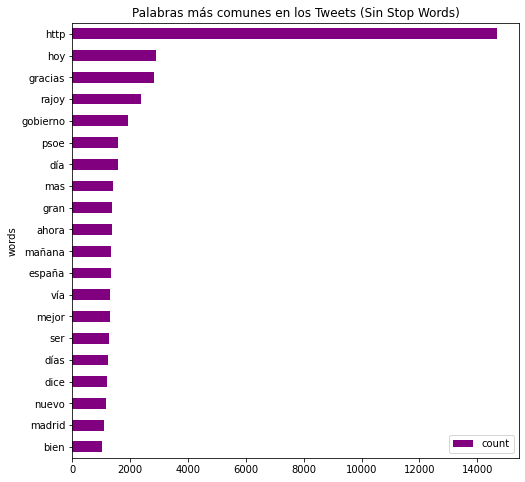

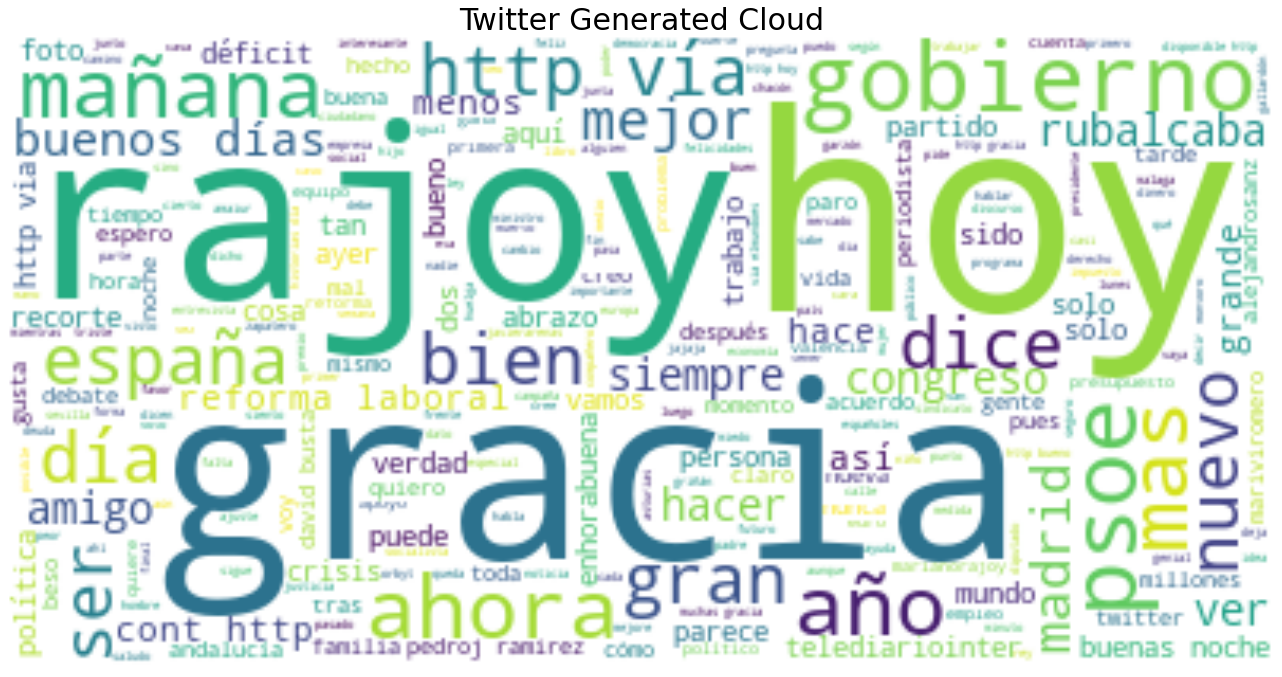

In [4]:
# Se crea un WordCloud con las 15 palabras que mas aparecen en el dataset (sin los stopwords )
all_words_nsw = list(itertools.chain(*out_df['tweet']))
counts_nsw = collections.Counter(all_words_nsw)
counts_nsw.most_common(15)


clean_tweets_nsw = pd.DataFrame(counts_nsw.most_common(20),
                             columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_tweets_nsw.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Palabras más comunes en los Tweets (Sin Stop Words)")
plt.show()

wc = WordCloud(background_color="white", max_words=2000)
clean_string = ','.join(all_words_nsw)
wc.generate(clean_string)
f = plt.figure(figsize=(50,50))
f.add_subplot(1,2, 1)
plt.imshow(wc, interpolation='bilinear')
plt.title('Twitter Generated Cloud', size=30)
plt.axis("off")
plt.show()

I join the list of lists of words and I study the positive-negative percentage present in the input files.

In [5]:
# Se pasa de una lista de listas de palabras a una lista de tweets limpios y se realiza un split en Train y en Test.

out_df['tweet'] = out_df['tweet'].apply(lambda x: ' '.join(x))
#out_df.to_csv('/Users/joey/Downloads/coronasentimet-master/preprocessed-training.csv',index=False)
#out_df = pd.read_csv("/Users/joey/Desktop/ENTREGA_ABID/preprocessed-training.csv", error_bad_lines=False, sep=',', header=0, names=['tweet','value'],encoding="UTF-8")



output_text = out_df['tweet'].values
y = out_df['value'].values


X_train, X_test, y_train, y_test = train_test_split(output_text, y, test_size=0.10, random_state=1000)




# Se obtiene el porcentaje de tweets positivos y negativos tanto en el dataset de train como de test.
print("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(X_train),
    (len(X_train[y_train == 0]) / (len(X_train)*1.))*100,
    (len(X_train[y_train == 1]) / (len(X_train)*1.))*100))

print("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(X_test),
    (len(X_test[y_test == 0]) / (len(X_test)*1.))*100,
    (len(X_test[y_test == 1]) / (len(X_test)*1.))*100))

print("\n\n\n")

Train set has total 44453 entries with 43.38% negative, 56.62% positive
Test set has total 4940 entries with 43.62% negative, 56.38% positive






The chi-square test helps you to solve the problem in feature selection by testing the relationship between the features. In feature selection, we aim to select the features which are highly dependent on the response. When two features are independent, the observed count is close to the expected count, thus we will have smaller Chi-Square value. So high Chi-Square value indicates that the hypothesis of independence is incorrect. In simple words, higher the Chi-Square value the feature is more dependent on the response and it can be selected for model training.

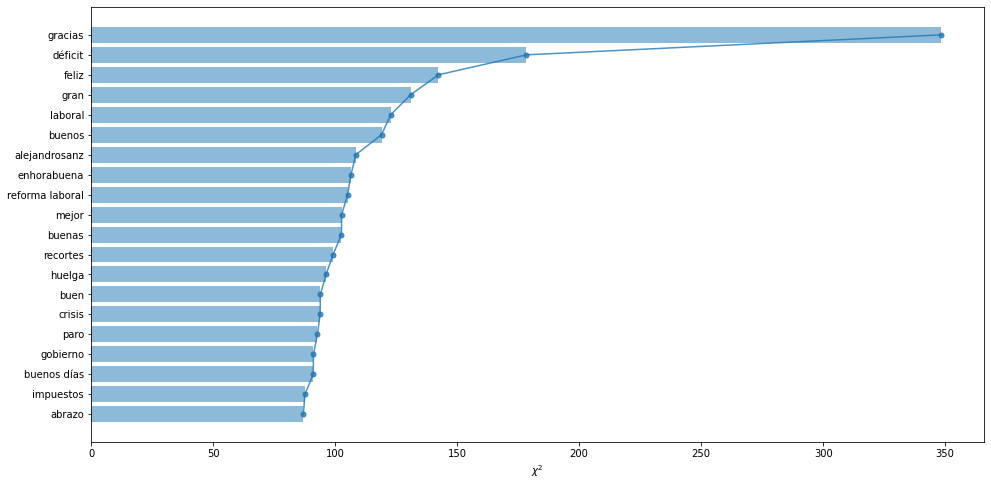

In [6]:
# Se obtiene una grafica con el chi Score de las palabras mas relevantes.
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=30000,ngram_range=(1, 3))
X_tfidf = tfidf.fit_transform(out_df['tweet'])
y = out_df['value']
chi2score = chi2(X_tfidf, y)[0]

plt.figure(figsize=(16,8))
scores = list(zip(tfidf.get_feature_names(), chi2score))
chi2 = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*chi2[-20:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')
plt.show();

Tokenizing is necessary in order to split the list of string into a list of lists of words. In addition, all the neural networks require to have inputs that have the same shape and size. However, when we pre-process and use the texts as inputs for our model (e.g. LSTM), not all the sentences have the same length. In other words,  some of the sentences are longer or shorter. We need to have the inputs with the same size and this is what padding does.

In [7]:
# Tokenizar y "paddear" los tweets.

from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index


print(X_train[2])


from keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

print(X_train[0, :])

[97, 40, 181, 1160, 1076, 1]
[ 197   84 2759   74    1    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


# Convolution1D (I)

1D Convolutional Layers
Convolutional Neural Networks (ConvNets) perform particularly well on computer vision problems due to their ability to operate convolutionally, that is extracting features from local input patches allowing for representation modularity and data efficiency. The same properties that make ConvNets the best choice for computer vision-related problems also make them highly significant to sequence processing. 1D convolution layers are also translation invariant in the sense that because the same input transformation is performed on every patch, a pattern learned at a certain position in a sentence can later be recognized at a different position. Similar to 2D ConvNets, 1D patches can be extracted from an input and output the maximum or average value, a process technically referred to as Max Pooling and Average Pooling respectively, and just as with 2D ConvNets, this is also used for reducing the length of the 1D input (technically known as subsampling).


 
- The Embedding layer is defined as the first hidden layer of a network. It must specify 3 arguments:

  - input_dim: This is the size of the vocabulary in the text data. F
  - output_dim: This is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word.
  - input_length: This is the length of input sequences, as you would define for any input layer of a Keras model. 


- The Conv1D layer creates a convolution kernel that is convolved with the layer input over a single spatial (or temporal) dimension to produce a tensor of outputs.


- Global max pooling operation for 1D temporal data downsamples the input representation by taking the maximum value over the time dimension.

https://medium.com/@romannempyre/sentiment-analysis-using-1d-convolutional-neural-networks-part-1-f8b6316489a2

In [8]:
#EVALUATION METRICS 
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))




#FIRST CONVOLUTIONAL MODEL
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy', f1_m, precision_m, recall_m])

    return model

In [9]:
%%capture
#Se comenta el grid search debido a su alto coste computacional.


'''
# Main settings
epochs = 20
#embedding_dim = 50
maxlen = 100
output_file = 'data/output.txt'


# Parameter grid for grid search
param_grid = dict(num_filters=[32, 64, 128],
                      kernel_size=[3, 5, 7],
                      vocab_size=[vocab_size],
                      embedding_dim=[30,35,50,64,80],
                      maxlen=[maxlen])
    
model = KerasClassifier(build_fn=create_model,
                            epochs=epochs, batch_size=8,
                            verbose=False)
    
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              cv=3, verbose=1, n_iter=3)
    
grid_result = grid.fit(X_train, y_train)

# Evaluate testing set
test_accuracy = grid.score(X_test, y_test)

    # Save and evaluate results
    
s = ('Running data set\nBest Accuracy : '
     '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
output_string = s.format(grid_result.best_score_,
            grid_result.best_params_,
            test_accuracy)
print(output_string)
      
'''

We proceed to create the model with the best hyperparameters obtained through Grid Search. I only use 4 epochs since if I used more, the model would suffer from overfitting and the value of "val_loss" would grow above an acceptable limit.

In [10]:
#print(grid_result.best_params_) --> {'vocab_size': 8201, 'num_filters': 32, 'maxlen': 100, 'kernel_size': 3, 'embedding_dim': 50}

best_model = create_model(32,3,vocab_size,300,maxlen)


hist = best_model.fit(X_train, y_train,
                    epochs= 4,
                    validation_data=(X_test, y_test),
                    batch_size=32, shuffle=True, verbose=1)

#loss, accuracy = best_model.evaluate(X_train, y_train, verbose=False)
#print("Training Accuracy: {:.4f}".format(accuracy))


print("\n\nTesting Accuracy: \n")



loss, accuracy, f1_score, precision, recall = best_model.evaluate(X_test, y_test, verbose=False)
print('Loss: ', loss)
print('Accuracy: ', accuracy)
print('F1-Score: ',f1_score)
print('Precision: ', precision)
print('Recall: ', recall)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Train on 44453 samples, validate on 4940 samples
Epoch 1/4
44453/44453 [==============================] - 78s 2ms/step - loss: 0.3605 - accuracy: 0.8365 - f1_m: 0.8565 - precision_m: 0.8521 - recall_m: 0.8732 - val_loss: 0.3109 - val_accuracy: 0.8638 - val_f1_m: 0.8742 - val_precision_m: 0.8884 - val_recall_m: 0.8666
Epoch 2/4
44453/44453 [==============================] - 82s 2ms/step - loss: 0.2178 - accuracy: 0.9129 - f1_m: 0.9216 - precision_m: 0.9211 - recall_m: 0.9265 - val_loss: 0.3096 - val_accuracy: 0.8747 - val_f1_m: 0.8863 - val_precision_m: 0.8845 - val_recall_m: 0.8939
Epoch 3/4
44453/44453 [==============================] - 75s 2ms/step - loss: 0.1196 - accuracy: 0.9560 - f1_m: 0.9599 - precision_m: 0.9590 - recall_m: 0.9629 - val_loss: 0.3465 - val_accuracy: 0.8682 - val_f1_m: 0.8829 - val_precision_m: 0.8626 - val_recall_m: 0.9094
Epoch 4/4
44453/44453 [==============================] - 78s 2ms/step - loss: 0.0554 - accuracy: 0.9809 - f1_m: 0.9827 - precision_m: 0.9822 

---
---
A plot with the comparison between the train and test acurracy is showed.

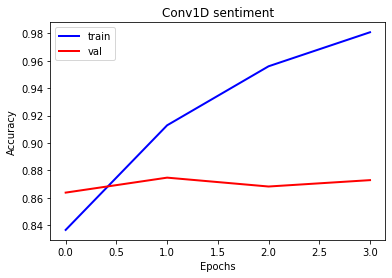

In [11]:
plt.figure()
plt.plot(hist.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('Conv1D sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend(loc='upper left')
plt.show()

It can be seen that the models tend to overfit as the loss reduces and the validation loss increases.

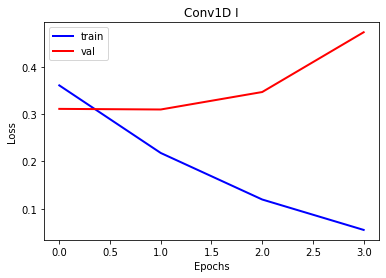

In [12]:
plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('Conv1D I')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(loc='upper left')
plt.show()

---
# Convolution1D (II)

Inspired in the model from the Keras documentation, it results in a much more faster model than the previous one and more accurate one.

In [13]:
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.datasets import imdb

# set parameters:
max_features = 5000
maxlen = 100
batch_size = 32
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 4


print('Build model...')
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))

model.add(Dropout(0.2)) #To force neurons to re-learn new weights.


# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))


# we use max pooling:
model.add(GlobalMaxPooling1D())


# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))


# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', f1_m, precision_m, recall_m])


hist2 = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test))

model.save("/Users/joey/Desktop/ENTREGA_ABID/segundo_modelo.h5")


print("\n\nTesting Accuracy: \n")
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=False)
print('Loss: ', loss)
print('Accuracy: ', accuracy)
print('F1-Score: ',f1_score)
print('Precision: ', precision)
print('Recall: ', recall)

Build model...
Train on 44453 samples, validate on 4940 samples
Epoch 1/4
44453/44453 [==============================] - 18s 398us/step - loss: 0.3647 - accuracy: 0.8316 - f1_m: 0.8541 - precision_m: 0.8484 - recall_m: 0.8740 - val_loss: 0.3396 - val_accuracy: 0.8559 - val_f1_m: 0.8612 - val_precision_m: 0.9157 - val_recall_m: 0.8194
Epoch 2/4
44453/44453 [==============================] - 17s 389us/step - loss: 0.2511 - accuracy: 0.8948 - f1_m: 0.9049 - precision_m: 0.9048 - recall_m: 0.9103 - val_loss: 0.2989 - val_accuracy: 0.8753 - val_f1_m: 0.8861 - val_precision_m: 0.8851 - val_recall_m: 0.8925
Epoch 3/4
44453/44453 [==============================] - 17s 378us/step - loss: 0.1883 - accuracy: 0.9229 - f1_m: 0.9303 - precision_m: 0.9303 - recall_m: 0.9342 - val_loss: 0.3090 - val_accuracy: 0.8747 - val_f1_m: 0.8858 - val_precision_m: 0.8871 - val_recall_m: 0.8902
Epoch 4/4
44453/44453 [==============================] - 18s 401us/step - loss: 0.1342 - accuracy: 0.9456 - f1_m: 0.9505

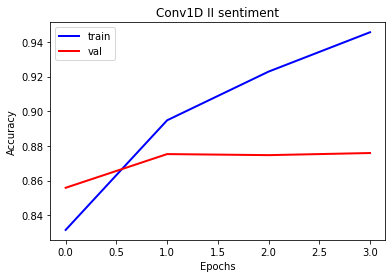

In [14]:
plt.figure()
plt.plot(hist2.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(hist2.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('Conv1D II sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend(loc='upper left')
plt.show()

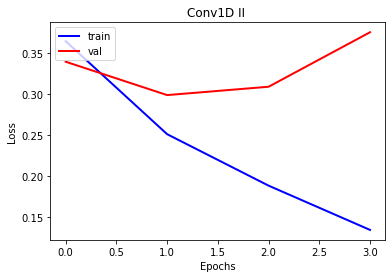

In [15]:
plt.figure()
plt.plot(hist2.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist2.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('Conv1D II ')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(loc='upper left')
plt.show()

---
# Bidirectional LSTM

Bidirectional Recurrent Neural Networks (BRNN) connect two hidden layers of opposite directions to the same output. With this form of generative deep learning, the output layer can get information from past (backwards) and future (forward) states simultaneously. BRNNs were introduced to increase the amount of input information available to the network. For example, multilayer perceptron (MLPs) and time delay neural network (TDNNs) have limitations on the input data flexibility, as they require their input data to be fixed. Standard recurrent neural network (RNNs) also have restrictions as the future input information cannot be reached from the current state. On the contrary, BRNNs do not require their input data to be fixed. Moreover, their future input information is reachable from the current state. BiLSTM networks, not only solve the long-term dependency problem, but they also capture the actual context of the text. 


BRNNs can be trained using similar algorithms to RNNs, because the two directional neurons do not have any interactions. Using bidirectional will run inputs in two ways, one from past to future and one from future to past and what differs this approach from unidirectional is that in the LSTM that runs backwards you preserve information from the future and using the two hidden states combined you are able in any point in time to preserve information from both past and future.

Moreover, they are designed to perform a sequences recognition or predictio as they have a flexible number of inputs and they allow cyclical connections between their neurons. This means that they are able to remember previous information and connect it to the current task.


In this case, I need to have three layers:

- Embedding Layer - modifies the integer representation of words into dense vectors
- Bidirectional LSTM Layer - connects two hidden layers of opposite directions to the same output
- Dense Layer - output layer with softmax activation

In [16]:
### import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

max_features = 20000  # Only consider the top 20k words
maxlen = 100  # Only consider the first 200 words of each movie review




def create_model2 (embedding_dim, max_features, maxlen, units):
    # Input for variable-length sequences of integers
    inputs = keras.Input(shape=(None,), dtype="int32")
    # Embed each integer in a 128-dimensional vector
    x = layers.Embedding(max_features, 128)(inputs)
    # Add 2 bidirectional LSTMs
    x = layers.Bidirectional(layers.LSTM(units, return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(units))(x)
    # Add a classifier
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.summary()
    model.compile("adam", "binary_crossentropy", metrics=['accuracy', f1_m, precision_m, recall_m])

    return model

In [17]:
%%capture
#Se comenta el grid search debido a su alto coste computacional.

'''
# Parameter grid for grid search
param_grid = dict(embedding_dim=[32,64,128,256],
                  max_features = [max_features],
                  maxlen=[maxlen],
                  units = [4,8,16,32,64,128])
    
model = KerasClassifier(build_fn=create_model2,
                            epochs=epochs, batch_size=16,
                            verbose=True)
    
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                              cv=2, verbose=1, n_iter=2)
    
grid_result = grid.fit(X_train, y_train)

# Evaluate testing set
test_accuracy = grid.score(X_test, y_test)

    
s = ('Running data set\nBest Accuracy : '
     '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
output_string = s.format(grid_result.best_score_,
            grid_result.best_params_,
            test_accuracy)
print(output_string)
'''

In [18]:
model3 = create_model2(64,20000,100,8) # Se crea un modelo con los mejores resultados del Grid Search
hist3 = model3.fit(X_train, y_train, batch_size=32, epochs=3, validation_data=(X_test, y_test))



print("\n|nTesting Accuracy: \n")



loss, accuracy, f1_score, precision, recall = model3.evaluate(X_test, y_test, verbose=False)
print('Loss: ', loss)
print('Accuracy: ', accuracy)
print('F1-Score: ',f1_score)
print('Precision: ', precision)
print('Recall: ', recall)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         2560000   
_________________________________________________________________
bidirectional (Bidirectional (None, None, 16)          8768      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 16)                1600      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 2,570,385
Trainable params: 2,570,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
1390/1390 [==============================] - 153s 110ms/step - loss: 0.3673 - accuracy: 0.8346 - f1_m: 0.85

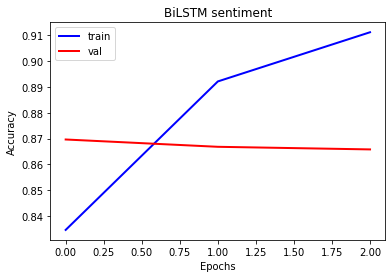

In [19]:
plt.figure()
plt.plot(hist3.history['accuracy'], lw=2.0, color='b', label='train')
plt.plot(hist3.history['val_accuracy'], lw=2.0, color='r', label='val')
plt.title('BiLSTM sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend(loc='upper left')
plt.show()

Overfitting in here is not as clear as in the previous models.

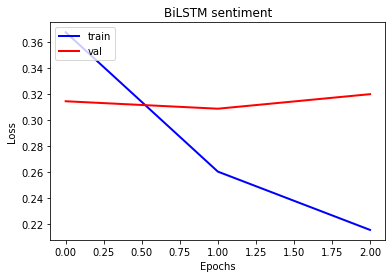

In [20]:
plt.figure()
plt.plot(hist3.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist3.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('BiLSTM sentiment')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend(loc='upper left')
plt.show()

---
# APPLICATION TO ACTUAL TWEETS

Now I will proceed to import the necessary libraries, concatenate all the twitter files that we have been collecting into one, process, normalize and tokenize them, and finally, predict their value with one of the models that I have created previously. I also made a function with provides a dynamic histogram of the predicted tweet value based on the date chosen.

In [21]:
import collections
from datetime import datetime
from googletrans import Translator
from IPython.display import Image as im
import itertools
import matplotlib.pyplot as plt
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.chunk.regexp import *
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
import numpy as np
import nltk
import pandas as pd
from PIL import Image
import re
import seaborn as sns
import ssl
import string
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
import xml.etree.ElementTree as et

I process the seven tweet "txt" files. Later, I concatenate them into only one file and select a sample of them which contains words like "coronavirus" or "covid-19".

In [22]:
df_1 = pd.read_csv("./tweets/tweets_1.txt",delimiter='|',header=None,names=['user','location','datetime','tweet'],
                 error_bad_lines=False,warn_bad_lines=False)
df_2 = pd.read_csv("./tweets/tweets_2.txt",delimiter='|',header=None,names=['user','location','datetime','tweet'],
                 error_bad_lines=False,warn_bad_lines=False)
df_3 = pd.read_csv("./tweets/tweets_3.txt",delimiter='|',header=None,names=['user','location','datetime','tweet'],
                 error_bad_lines=False,warn_bad_lines=False)
df_4 = pd.read_csv("./tweets/tweets_4.txt",delimiter='|',header=None,names=['user','location','datetime','tweet'],
                 error_bad_lines=False,warn_bad_lines=False)
df_5 = pd.read_csv("./tweets/tweets_5.txt",delimiter='|',header=None,names=['user','location','datetime','tweet'],
                 error_bad_lines=False,warn_bad_lines=False)
df_6 = pd.read_csv("./tweets/tweets_6.txt",delimiter='|',header=None,names=['user','location','datetime','tweet'],
                 error_bad_lines=False,warn_bad_lines=False)
df_7 = pd.read_csv("./tweets/tweets_7.txt",delimiter='|',header=None,names=['user','location','datetime','tweet'],
                 error_bad_lines=False,warn_bad_lines=False)

df_1 = pd.concat([df_1, df_2, df_3,df_4,df_5,df_6,df_7]) # Concatenacion de los 3 ficheros.


searchfor = ["covid", "covid-19", "desescalada", "COVID-19", "coronavirus", "psoe", "cuarentena", "crisis", "pp", "fase"]
df_1 = df_1[df_1['tweet'].str.contains('|'.join(searchfor)) == True]


df_1['tweet'].head(50)

8       @BldCancerDoc @DrMiguelPerales @sloan_ketterin...
87                              Hoppas kan man ju alltid!
133            Las fases del desconfinamiento acelerado 😂
280     @CindyPaolaadams @avantiscalda Pero es un appa...
369     Pendant ce confinement je n'aurais pas fait de...
398     @VHMSirena @Juana_Buigues @Estherppunto @Elena...
401     ¿No les parece que los “oppening” de algunos á...
407                        @rakkyripper asi hemos salido😏
416     REINA DE ESPAÑA @_ANAMILAN_ #anamilan #instagr...
474     Day 6 Wishing @WWERomanReigns a happy Wednesda...
494     @angelinesyague @Juana_Buigues @Estherppunto @...
580     🖤💪🏻 @mindandtangle #yomequedoencasa #yomequedo...
588     Un appel de Vincent Lindon: «Comment ce pays s...
632     It is somewhat disappointing that @f1 have dec...
733     MOOD 🤍 #cuarentena #StayHome #love https://t.c...
833        cuando Barcelona no pase a la fase 1 el lunes:
848     Los mayores también pasean. #Madrid #Desescala...
876     Pero c

---
Preprocessing and text cleaning techniques.

In [23]:
pd.set_option('display.max_colwidth', -1)


from langdetect import detect


# Eliminamos posibles filas vacías y duplicadas
df_1 = df_1.dropna()
df_1 = df_1.drop_duplicates()

# Eliminamos tweets incompletos (aquellos que tienen una parte del tweet y un enlace al tweet completo)
df_1 = df_1[~df_1['tweet'].str.contains("https://", regex=False)]

# Eliminar las menciones a personas @username
df_1['tweet'] = [re.sub("@[A-Za-z0-9]+","", tweet) for tweet in df_1['tweet']]


# Convertimos fecha y hora a formato datetime para trabajar con él
df_1['datetime'] =  pd.to_datetime(df_1['datetime'], format='%a %b %d %H:%M:%S %z %Y')


#Reordeno el campo index una vez que se hayan eliminado tweets
df_1 = df_1.reset_index()
df_1 = df_1.drop(columns=['index'])


def find_hashtags(tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet)

ls = df_1['tweet'].tolist()
df_1['hashtags'] = df_1['tweet'].apply(find_hashtags)



a = 0
for x in df_1['tweet']:
    try:
        if (detect(x) == 'es'):
            a = a + 1
        else:
            df_1 = df_1.drop([a])
            a = a + 1
    except:
        language = "error"
        df_1 = df_1.drop([a])
        a = a + 1
        
df_1 = df_1.reset_index()



print(df_1)
print(df_1.shape)


def clean_text_round1(text):
    #Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.
    text = text.lower()
    text = re.sub('\[.*?¿\]\%', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r"http\S+", "", text) 
    text = re.sub('@[^\s]+', '', text) #-->remove usernames
    text = re.sub(r'#([^\s]+)', r'\1', text) #-->remove the # in #hashtag
    text = text.replace("''", '')
    return text
 

# Apply a second round of cleaning
def clean_text_round2(text):
    #Get rid of some additional punctuation and non-sensical text that was missed the first time around.
    text = re.sub('[‘’“”…«»]', '', text)
    text = re.sub('\n', ' ', text)
    return text
  
    
round1 = lambda x: clean_text_round1(x)
df_1['tweet'] = df_1['tweet'].apply(clean_text_round1)
df_1['tweet']
print(df_1['tweet'])

   
round2 = lambda x: clean_text_round2(x)
df_1['tweet'] = df_1['tweet'].apply(clean_text_round2)
df_1['tweet']
print(df_1['tweet'])


# Se eliminan todos los stopwords en español
df_1["tweet"] = df_1["tweet"].str.split()
stop = stopwords.words('spanish')
df_1['tweet'] = df_1['tweet'].apply(lambda x: [item for item in x if item not in stop])
print(df_1['tweet'])


# Se eliminan las palabras con una longitud de dos caracteres o menor.
df_1['tweet'] = df_1['tweet'].apply(lambda x: [item for item in x if len(item)>=2]) 
print(df_1['tweet'])
print('\n\n\n\n')


df_1['tweet'] = df_1['tweet'].apply(lambda x: ' '.join(x))

df_1.to_csv('/Users/joey/Downloads/coronasentimet-master/preprocessed-text.csv',index=False)

output_text = df_1['tweet'].values
print(df_1['tweet'])


print('\n\n\n')
print(output_text)


# Tokenizar y "paddear" los tweets.
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(output_text)
X_test_2 = tokenizer.texts_to_sequences(output_text)
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index


print('\n\n\n')
print(X_test_2[2])


from keras.preprocessing.sequence import pad_sequences
maxlen = 100
X_test_2 = pad_sequences(X_test_2, padding='post', maxlen=maxlen)
X_test_2

<ipython-input-23-e7e55be0fec3>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


      index              user location                  datetime  \
0     2      @dgcomas          [,]     2020-05-06 16:56:45+00:00   
1     3      @bc8b5cdc161146e  [,]     2020-05-06 16:58:09+00:00   
2     5      @PJYEPEZ          [,]     2020-05-06 16:59:26+00:00   
3     8      @genisputh        [,]     2020-05-06 17:04:00+00:00   
4     9      @alepalcor        [,]     2020-05-06 17:04:35+00:00   
...  ..             ...        ...                           ...   
4999  7208   @Enrique80256492  [,]     2020-05-14 22:46:57+00:00   
5000  7210   @PatriiTAcosta    [,]     2020-05-14 22:47:25+00:00   
5001  7211   @lola_lozano01    [,]     2020-05-14 22:47:27+00:00   
5002  7212   @cecilos          [,]     2020-05-14 22:47:32+00:00   
5003  7213   @LeonDalitina5    [,]     2020-05-14 22:48:03+00:00   

                                                                                                                          tweet  \
0     Las fases del desconfinamiento acelerado 😂    

array([[  27,  613, 3337, ...,    0,    0,    0],
       [1997,    0,    0, ...,    0,    0,    0],
       [ 739,   64, 3338, ...,    0,    0,    0],
       ...,
       [  49,   97,  518, ...,    0,    0,    0],
       [  45, 1038, 1858, ...,    0,    0,    0],
       [ 757,    7,   15, ...,    0,    0,    0]], dtype=int32)

---
As all the collected tweets are from May, I create a function to generate a new column composed by the 31 days of the month.

In [24]:
round2 = lambda x: int(x.day)
df_1['day'] = df_1['datetime'].apply(round2)

---
Finally, I predict the value for the random sample of tweets selected.

In [25]:
result = model3.predict(X_test_2)
print(type(result))



def integerr(result):
    for x in range(len(result)):
        if result[x] >= 0.5:
            result[x] = 1
        else:
            result[x] = 0
    return result



result = integerr(result).tolist()
print(type(result))


flat_list = [item for sublist in result for item in sublist]
flat_list = [int(i) for i in flat_list]

flat_list




df_1['value'] = flat_list

df_1 = df_1.reset_index()


print(df_1)

<class 'numpy.ndarray'>
<class 'list'>
      level_0  index              user location                  datetime  \
0     0        2      @dgcomas          [,]     2020-05-06 16:56:45+00:00   
1     1        3      @bc8b5cdc161146e  [,]     2020-05-06 16:58:09+00:00   
2     2        5      @PJYEPEZ          [,]     2020-05-06 16:59:26+00:00   
3     3        8      @genisputh        [,]     2020-05-06 17:04:00+00:00   
4     4        9      @alepalcor        [,]     2020-05-06 17:04:35+00:00   
...  ..       ..             ...        ...                           ...   
4999  4999     7208   @Enrique80256492  [,]     2020-05-14 22:46:57+00:00   
5000  5000     7210   @PatriiTAcosta    [,]     2020-05-14 22:47:25+00:00   
5001  5001     7211   @lola_lozano01    [,]     2020-05-14 22:47:27+00:00   
5002  5002     7212   @cecilos          [,]     2020-05-14 22:47:32+00:00   
5003  5003     7213   @LeonDalitina5    [,]     2020-05-14 22:48:03+00:00   

                                    


---



A dynamic plot is made by dimensioning a time window selected by the user.

In [26]:
#!pip3 install ipywidgets
#!jupyter nbextension enable --py widgetsnbextension

import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
import ipywidgets


origen = ipywidgets.Dropdown(options=list(range(32)), value=1, description='Inicio:')
final = ipywidgets.Dropdown(options=list(range(32)), value=31, description='Final:')


display(origen, final)


out = widgets.Output()
display(out)



def get_and_plot(b):
    with out:
        clear_output()
        df2 = df_1.copy()
        df2 = df2[df2.day > origen.value]  
        df2 = df2[df2.day < final.value]
        aux = origen.value
        df2.groupby(['day','value']).size().unstack().plot(kind='bar',stacked=True)
        plt.show()        


      
    
origen.observe(get_and_plot, names='value')
final.observe(get_and_plot, names='value')

Dropdown(description='Inicio:', index=1, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17…

Dropdown(description='Final:', index=31, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17…

Output()

---
Some relevant events in order to help the selection of dates in the graphic of above.

In [27]:
eventos = pd.read_csv("./eventos.csv",delimiter='|',header=None,names=['datetime','tipo','info','zona'],
                 error_bad_lines=False,warn_bad_lines=False)
eventos

,datetime,tipo,info,zona
0,datetime,tipo,info,zona
1,06-05-2020 09:59,Prórroga,Pleno para solicitud de la cuarta prórroga (hasta 24/05),NaN
2,06-05-2020 10:05,Prórroga,Comparecencia del Presidente en el pleno,NaN
3,06-05-2020 11:35,Cifras,Nuevos contagios: 927 (+32) - Fallecimientos: 213 (-31),NaN
4,06-05-2020 14:22,Desescalada,La Xunta de Galicia solicita el paso a la fase 1,Galicia
5,06-05-2020 18:18,Prórroga,Aprobación de la cuarta prórroga (hasta 24/05),NaN
6,06-05-2020 19:09,Desescalada,La Comunidad de Madrid solicita el paso a la fase 1,Com. Madrid
7,07-05-2020 11:18,Cifras,Nuevos contagios: 927 (+32) - Fallecimientos: 213 (-31),NaN
8,07-05-2020 22:38,Desescalada,Dimite la directora de Salud Pública de la Comunidad de Madrid,Com. Madrid
9,08-05-2020 12:33,Cifras,Nuevos contagios: 1178 (+251) - Fallecimientos: 229 (+16),NaN


------

# CONCLUSION

Surprisingly for me, Bidirectional LSTM is not the best model, as the second Convolutional1d Keras Model achieves a higher test accuracy and is lighter than the other two models. I would also like to highlight that the models have been trained with a few number of epochs in order to avoid overfitting. 

To conclude, I would like to say that two of the current most popular machine learning have been applied and optimized by a Grid Search technique. The results obtained (aprox. 87% of accuracy) are really brilliant, as the the NLP theorical limit is normally set on 90% of accuracy due to the lack of total objectiveness. Moreover, text cleaning techniques have been applied to normalize the tweet texts and to create a common format for them. Some illustrations as the WordCloud or the Chi Square plot aim to illustrate in a clearer way the most important words in the dataset as they are more correlated to the final result or value than the rest of the dataset words. I would also like to thank my teammates as these results would not have been accomplished without them and their hard work.

Additionally, I want to express my "relative" dissatisfaction with the project as I find it really interesting and I did not have the amount of time that I would have wanted to work in it. I would have also loved extracting some more features and some additional post-analysis conclusions, but it was really difficult due to the lack of time what we are suffering in this month. However, I think that I made such an complete job, personally providing my team:

- A complete dataset composed by more than 70.000 labeled tweets.
- Some text cleaning techniques such as the clean_text_round functions.
- Some illustrations of word relevance and frequency: Chi Square and Word Cloud.
- Three modern neural networks models.
- A filter to load only tweets containing words related to covid-19.
- A dynamic histogram of positive/negative sentiments.